In [ ]:
!pip uninstall -y torch torchvision spikingjelly pycocotools matplotlib
!pip install torch torchvision spikingjelly pycocotools matplotlib --no-cache-dir


Found existing installation: torch 2.6.0+cpu
Uninstalling torch-2.6.0+cpu:
  Successfully uninstalled torch-2.6.0+cpu
Found existing installation: torchvision 0.21.0+cpu
Uninstalling torchvision-0.21.0+cpu:
  Successfully uninstalled torchvision-0.21.0+cpu
Found existing installation: matplotlib 3.10.0
Uninstalling matplotlib-3.10.0:
  Successfully uninstalled matplotlib-3.10.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB

In [ ]:
# Download the train images
!wget http://images.cocodataset.org/zips/train2017.zip -P /content/Dataset/

# Unzip the images
!unzip /content/Dataset/train2017.zip -d /content/Dataset/train2017/

# Download the annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P /content/Dataset/

# Unzip the annotations
!unzip /content/Dataset/annotations_trainval2017.zip -d /content/Dataset/annotations/

Streaming output truncated to the last 5000 lines.
 extracting: /content/Dataset/train2017/train2017/000000249290.jpg  
 extracting: /content/Dataset/train2017/train2017/000000025529.jpg  
 extracting: /content/Dataset/train2017/train2017/000000316928.jpg  
 extracting: /content/Dataset/train2017/train2017/000000337866.jpg  
 extracting: /content/Dataset/train2017/train2017/000000547768.jpg  
 extracting: /content/Dataset/train2017/train2017/000000423162.jpg  
 extracting: /content/Dataset/train2017/train2017/000000224149.jpg  
 extracting: /content/Dataset/train2017/train2017/000000117841.jpg  
 extracting: /content/Dataset/train2017/train2017/000000251660.jpg  
 extracting: /content/Dataset/train2017/train2017/000000110997.jpg  
 extracting: /content/Dataset/train2017/train2017/000000424728.jpg  
 extracting: /content/Dataset/train2017/train2017/000000384745.jpg  
 extracting: /content/Dataset/train2017/train2017/000000475535.jpg  
 extracting: /content/Dataset/train2017/train2017/00

In [ ]:
# Step 1: Install Dependencies


import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
from spikingjelly.activation_based import neuron, functional, layer
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image



In [ ]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Step 2: Define Transformations
data_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



Using device: cpu


In [ ]:
# Step 3: Custom Dataset Loader for COCO with JSON Annotations
import json
class CustomCocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation_file, transform=None):
        self.root = root
        self.transform = transform
        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)
        self.images = self.coco_data['images']
        self.annotations = {ann['image_id']: ann for ann in self.coco_data['annotations']}

    def __len__(self):
        return min(len(self.images), 500)  # Use only the first 5000 images

    def __getitem__(self, index):
        image_info = self.images[index]
        image_path = f"{self.root}/{image_info['file_name']}"
        try:
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None, None

        annotation = self.annotations.get(image_info['id'], {'category_id': 0})
        label = annotation['category_id']
        return image, label



In [ ]:
# Initialize Dataset and DataLoader
dataset = CustomCocoDataset(
    root='/content/Dataset/train2017/train2017',
    annotation_file='/content/Dataset/annotations/annotations/instances_train2017.json',
    transform=data_transform
)
#dataset = [item for item in dataset if item[0] is not None]
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=1, pin_memory=True)



In [ ]:
# Step 4: Convert CNN to SNN using SpikingJelly
class SNNResNet(nn.Module):
    def __init__(self, num_classes=5):
        super(SNNResNet, self).__init__()
        resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        self.lif = neuron.LIFNode(tau=1.7)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.lif(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = SNNResNet().to(device)



In [ ]:
# Step 5: Define Loss, Optimizer, and Scaler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scaler = torch.amp.GradScaler('cpu')


In [ ]:
def train_model(model, dataloader, criterion, optimizer, epochs=2):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in dataloader:
            if images is None or labels is None:
                continue

            images = images.to(device)
            labels = torch.tensor([min(label, 4) for label in labels]).to(device)

            optimizer.zero_grad()
            functional.reset_net(model)

            with torch.amp.autocast('cpu'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

            # Calculate predictions and accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(dataloader)
        epoch_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

train_model(model, dataloader, criterion, optimizer)


Epoch [1/2], Loss: 1.4132, Accuracy: 75.60%
Epoch [2/2], Loss: 1.2560, Accuracy: 75.60%


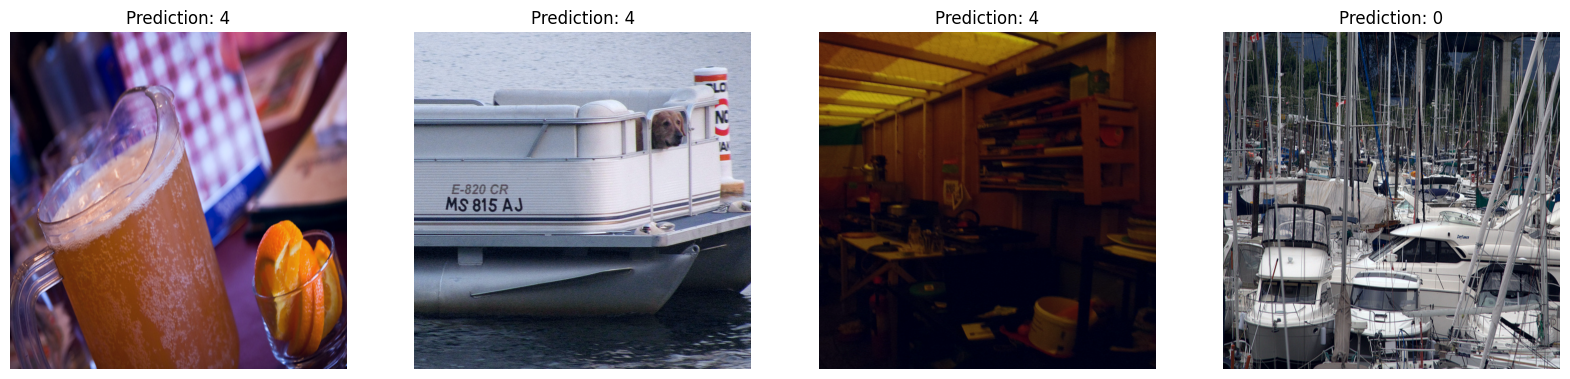

Training and visualization completed!


In [ ]:
@torch.no_grad()
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    functional.reset_net(model)  # Reset neurons to avoid state accumulation

    images, targets = next(iter(dataloader))
    images = images[:num_images].to(device)

    if len(images) != num_images:
        print("Warning: Not enough images in the batch. Adjusting.")
        num_images = len(images)

    outputs = model(images)
    predictions = torch.argmax(outputs, dim=1)

    fig, axs = plt.subplots(1, num_images, figsize=(20, 10))
    for i in range(num_images):
        img = images[i].cpu().permute(1, 2, 0) * 0.225 + 0.45
        axs[i].imshow(img)
        axs[i].set_title(f"Prediction: {predictions[i].item()}")
        axs[i].axis('off')
    plt.show()

# Ensure consistent batch size
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

visualize_predictions(model, dataloader)
print("Training and visualization completed!")
